In [1]:
import glob, os, sys
from pathlib import Path

import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
from tabulate import tabulate
from pytorch_networks_convae import *
from prepare_gaia_ini import create_ini_file
import argparse
from datasetio import *
import copy
from scaler import *
import time

pathsave = "/plp_user/agar_sh/gaia-git/python/modules/"
sys.path.insert(0, pathsave)
from gaia import *
import pickle
from matplotlib.animation import FuncAnimation

from calculate_profiles import calc_mlp_profile

In [2]:
data_dir = "/plp_scr1/agar_sh/data/TPH/"

pre = "/plp_user/agar_sh/PBML/pytorch/TPH/MLP/Paper/"
with open(pre + 'los.pkl', 'rb') as file: 
    los = pickle.load(file) 

In [3]:
gpu_number = -1
c_h = 16
use_symm = True 
repeats = 6
kernel = 5
warm_up_steps = 0
intervene_TS = 100000000000
t_end = 0.1
mode = "ML_STOKES"
save_steps = 100
advection_scheme = 1
#raq = 0.526931
#fkt = 24964307.0 
#fkp = 16.34974624
raq = 6.79733173 
fkt = 475523342.0 
fkp = 2.58574662
p_pred = False
noise = 0.0
loss_type = "curl"
batch_size = 16
advect = False
loss_scale = True 
levels = 6
l2_reg = 0.0
blurr = False
network = "fluidnet"

In [4]:
if mode=="GAIA":
    simulation = "raq_" + str(raq) + "_fkt_" + str(fkt) + "_fkv_" + str(fkp) 
else:
    simulation = network + "raq_" + str(raq) + "_fkt_" + str(fkt) + "_fkv_" + str(fkp) + "_f" + str(
             c_h) + "_symm" + str(use_symm) + "_r" + str(repeats) + "_k" + str(
             kernel) + "_p" + str(p_pred) + "_l" + loss_type + "_b" + str(batch_size
              ) + "_ad" + str(advect) + "_lev" + str(levels) + "_l_sc" + str(loss_scale) + "_l2_" + str(l2_reg) + "_bl" + str(blurr)
 
simulation_dir = "/plp_scr2/PLAGeS/CONVNN/GAIA_ML_RUNS/" + "raq_" + str(raq) + "_fkt_" + str(fkt) + "_fkv_" + str(fkp) + "/"
CaseID = mode

# "GAIA"             : fully gaia
# "ML"               : fully ml with gaia every n steps
# "ML_STOKES"        : ml for stokes solve only
# "ML_PRECONDITIONER": ml stokes prediction with ierative solver

gaia_dir = "/plp_scr2/PLAGeS/CONVNN/GAIA_ML_RUNS/" + simulation + "/"
if not os.path.exists(gaia_dir):
    os.makedirs(gaia_dir)

y_pred_nn_pointwise, y_prof = calc_mlp_profile([raq], [fkt], [fkp], gaia_dir)

for f in ["GaiaM", "libgaia.so", "ini", "Gaia.ini"]:
    if os.path.exists(gaia_dir+"/"+f):
        os.remove(gaia_dir+"/"+f)

    if f=="ini":
        os.symlink("/plp_scr2/PLAGeS/CONVNN/GAIA_ML_RUNS/"+f, gaia_dir+"/"+f)
    else:
        shutil.copyfile("/plp_scr2/PLAGeS/CONVNN/GAIA_ML_RUNS/"+f, gaia_dir+"/"+f)

if mode!="GAIA":
    pathlist = Path(simulation_dir[:-1]+ "_SAVEDSNAPS").glob('**/*SNAP*')
    for path in pathlist:
        # because path is object not string
        file = str(path)   
        
        file = file.split("/")[-1].replace("GAIA",mode)
        shutil.copyfile(path, gaia_dir+file)
    #for filepath in glob.iglob('gaia_dir/*SNAP*'):
    #    print(filepath)

f_gaia_ini = gaia_dir + "/Gaia.ini"

act_fn = "gelu"
r_p    = "replicate"
dilation = 1
a_bound   = 10
use_skip = False
debug = False
spectral_conv = False
d_r = 0.0

nn_dir = "/plp_user/agar_sh/PBML/pytorch/TPH/CONVNN/trained_networks/"

f_nn   =    network + "_levels_" + str(levels) + "_" + act_fn + \
            "_" + str(c_h) + "_" + r_p + "_" + loss_type  +  \
            "_" + str(use_symm) + "_ab" + str(a_bound) + "_b" + str(batch_size) + \
            "_r" + str(repeats) + "_k" + str(kernel) + \
            "_ad" + str(advect) + "_p_pred" + str(p_pred) + \
            "_l2" + str(l2_reg) + "_l_sc" + str(loss_scale) + "_deb" + str(debug) 
if blurr:
    f_nn += "blurr"
nn_dir = nn_dir + f_nn + "/"

In [5]:
def get_model(c_h, repeats, kernel, use_symm, p_pred, blurr):
    
    if loss_type == "curl":
        c_i = 7
        c_o = 2
    else:
        c_i = 7
        c_o = 3

    if not p_pred:
        c_o -= 1
    
    model_uvp = FluidNet(levels, c_i, c_h, c_o, device, act_fn, r_p, loss_type, 
                         use_symm=use_symm, dilation=dilation, a_bound=a_bound,
                        repeats=repeats, use_skip=use_skip, f=kernel, p_pred=p_pred, blurr=blurr).double().to(device)
    
    return model_uvp

In [6]:
colors = ["r-", "g-", "b-", "c-", "y-", "m-"] 

nns = [f_nn]

last_epochs = []

for counter, f_nn in enumerate(nns):
    
    nn_dir = "/plp_user/agar_sh/PBML/pytorch/TPH/CONVNN/trained_networks/"
    nn_dir = nn_dir + f_nn + "/"
                
    with open(nn_dir + "fluidnet_uvpT.txt") as fw:
        lines = fw.readlines()
    fw.close()
    loss_u       = []
    loss_v       = []
    loss_p       = []
    loss_mass    = []
    loss_cv_u    = []
    loss_cv_v    = []
    loss_cv_p    = []
    loss_cv_mass = []
    
    for l in lines[1:]:
        ll    = l[l.index("[")+1:l.index("],[")].split(",")
        l_r   = l[l.index("],[")+3:]
        ll_cv = l_r[:l_r.index("],")].split(",")                   

        loss_u.append([float(ll[0])])
        loss_v.append([float(ll[1])])
        loss_p.append([float(ll[2])])    
        loss_mass.append([float(ll[3])+1e-16])
        
        loss_cv_u.append([float(ll_cv[0])])
        loss_cv_v.append([float(ll_cv[1])])
        loss_cv_p.append([float(ll_cv[2])])
        loss_cv_mass.append([float(ll_cv[3])+1e-16])

    last_epochs.append(len(loss_u)-1)

# In[ ]:

if "ML" in mode:
    if torch.cuda.is_available() and gpu_number >-1:
        device = torch.device("cuda:" + str(gpu_number)) 
    else:
        device = torch.device("cpu")
        
    epoch = last_epochs[-1]-1

    model_uvp = get_model(c_h, repeats, kernel, use_symm, p_pred, blurr).double().to(device)
    print(count_parameters(model_uvp))
    
    model_uvp.load_state_dict(torch.load(nn_dir + str(epoch) + "_fluidnet_uvp.pt", map_location=device))
    model_uvp.eval()
    print("loaded epoch " + str(epoch))

223171
loaded epoch 111


/tmp/ipykernel_79662/2695427747.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_uvp.load_state_dict(torch.load(nn_dir + str(epoch) + "_fluidnet_uvp.pt", map_locat

In [7]:
raq = torch.tensor(raq, dtype=torch.float64) 
fkt = torch.tensor(fkt, dtype=torch.float64) 
fkp = torch.tensor(fkp, dtype=torch.float64) 
raq_nd = (raq-0.12624371)/(9.70723344-0.12624371)
fkt_nd = (torch.log10(fkt)-6.00352841978384)/(
         9.888820429862925-6.00352841978384)
fkp_nd = (torch.log10(fkp)-0.005251646002323797)/(
         1.9927988938926755-0.005251646002323797)
snapshots = {}
T_vec  = {}
t_vec  = {}
TS_vec = {}
scaler = np.exp((raq/10)*1.80167667 + np.log(fkt)*0.4330392 + np.log(fkp)*-0.46052953 )*5 

/tmp/ipykernel_79662/1757495636.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scaler = np.exp((raq/10)*1.80167667 + np.log(fkt)*0.4330392 + np.log(fkp)*-0.46052953 )*5


In [8]:
if mode=="ML":
    model_AD = ADNet(device=device, CN_max=1.0).double().to(device)
    model_AD.eval()
    ts_net = TS(model_uvp, model_AD, device=device, ts=1, 
                advection_scheme=advection_scheme, scale=loss_scale, p_pred=p_pred, net=network).double().to(device)
    print(ts_net)
    torch.compile(ts_net)
    ts_net.eval()
    
elif mode=="ML_STOKES" or mode == "ML_PRECONDITIONER":
    model_AD = None
    ts_net = TS(model_uvp, model_AD, device=device, ts=1, 
                advection_scheme=advection_scheme, scale=loss_scale, p_pred=p_pred, net=network).double().to(device)
    print(ts_net)
    torch.compile(ts_net)
    ts_net.eval()

    model_AD_explicit = ADNet(device=device, CN_max=0.9).double().to(device)
    model_AD_explicit.eval()
    ts_net_explicit = TS(model_uvp, model_AD_explicit, device=device, ts=1, 
                advection_scheme=advection_scheme, scale=loss_scale, p_pred=p_pred, net=network).double().to(device)
    print(ts_net)
    torch.compile(ts_net_explicit)
    ts_net_explicit.eval()
    
create_ini_file(f_gaia_ini, mode, raq.item(), fkt.item(), fkp.item(), 
                advection_scheme, intervene_TS, warm_up_steps, CaseID)

T_vec[mode]  = []
t_vec[mode]  = []
TS_vec[mode] = []

snapshots[mode] = {}
for var in ["v", "P", "T"]:
    snapshots[mode][var] = []
t      = 0
n_step = 0

os.chdir(gaia_dir)

sim = Direct()
sim.init1()
sim.iniLoad("ini/default.ini")
sim.iniLoad(f_gaia_ini)
sim.init2()
    
state  = sim.getState()
T_vec[mode].append(np.copy(state["T"].mean()))
t_vec[mode].append(np.copy(t))

while n_step<warm_up_steps-1:
    print(n_step)
    dt = sim.doTimestep()
    state  = sim.getState()
    print("------------------")
    n_step += 1

TS(
  (stokes): FluidNet(
    (conv): ModuleList(
      (0): FluidLayer(
        (layers): ModuleList(
          (0): SymmetricConv2d(7, 16, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=replicate)
          (1): GroupNorm(4, 16, eps=1e-05, affine=True)
        )
        (act): GELU(approximate='none')
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): Conv2d(103, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
      (3): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    )
    (gn): ModuleList(
      (0): GroupNorm(4, 16, eps=1e-05, affine=True)
    )
    (pool): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
    (unpool): ModuleList(
      (0-4): 5 x Upsample(size=(128, 512), mode='bicubic')
    )
    (act): GELU(approximate='none')
    (convs): ModuleList(
      (0-5): 6 x Mo

Pressure fixed at rank 0 in cell 7707.


VISCOSITY: grad(ln visc) mag_min: 0.00426473 mag_max: 435.775 min: 2.15939e-09 max: 0.996237 Contrast: 4.61352e+08 Limit at: 2.15939e+11
Writing ./PX_OUT_ML_STOKES_91 
Writing ./PX_OUT_ML_STOKES_91 done.
Area from cells: 4 Analytical: 4


0:Init done


In [9]:
sims = torch.load(data_dir + "/sims.pt")

simulation = "raq_" + str(raq.item()) + "_fkt_" + str(fkt.item()) + "_fkv_" + str(fkp.item()) 
    
gaia_dir = "/plp_scr2/PLAGeS/CONVNN/GAIA_ML_RUNS/" + simulation + "/"
print(gaia_dir)
with open(gaia_dir + 'snapshots_GAIA.pkl', 'rb') as file: 
    snapshots_gaia = pickle.load(file) 

with open(gaia_dir + 't_vec_GAIA.pkl', 'rb') as file: 
    t_t = pickle.load(file) 
with open(gaia_dir + 'T_vec_GAIA.pkl', 'rb') as file: 
    T_t = pickle.load(file) 

with open(gaia_dir + 'TS_vec_GAIA.pkl', 'rb') as file: 
    TS_t = pickle.load(file) 

/tmp/ipykernel_79662/569831770.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sims = torch.load(data_dir + "/sims.pt")


/plp_scr2/PLAGeS/CONVNN/GAIA_ML_RUNS/raq_6.79733173_fkt_475523342.0_fkv_2.58574662/


In [10]:
xcc = torch.tensor(np.copy(state["pos"][:,0]), dtype=torch.float64).view(1,1,128,506)
ycc = torch.tensor(np.copy(state["pos"][:,1]), dtype=torch.float64).view(1,1,128,506)
sdf = torch.zeros_like(xcc)
sdf[:,:,0,:]  = 1.
sdf[:,:,-1,:] = 1.
sdf[:,:,:,0]  = 1.
sdf[:,:,:,-1] = 1.
sdf2 = torch.ones_like(xcc)
sdf2[:,:,0,:]  = 0.
sdf2[:,:,-1,:] = 0.
sdf2[:,:,:,0]  = 0.
sdf2[:,:,:,-1] = 0.


def ad_gaia(t, n_step, Tp, u, v):
    state  = sim.getState()
    state["T"][:] = Tp.detach().cpu().numpy().flatten()

    u    = u.detach().cpu().numpy().flatten()
    v    = v.detach().cpu().numpy().flatten()

    state["v"][:,:] = np.concatenate((u.reshape(-1,1),
                                      v.reshape(-1,1),
                                      np.zeros_like(u.reshape(-1,1))),
                                      axis=1
                                      )
    
    dt = sim.doTimestep()
    state = sim.getState()
    return state

In [12]:
t_ind = 4
Tp  = torch.tensor(snapshots_gaia["T"][t_ind]).view(1,1,128,506)
u_g = torch.tensor(snapshots_gaia["v"][t_ind][:,0]).view(1,1,128,506)
v_g = torch.tensor(snapshots_gaia["v"][t_ind][:,1]).view(1,1,128,506)

state = ad_gaia(t, n_step, Tp, u_g, v_g)
T_g   = np.copy(state["T"]).reshape(1,128,506)

for i in range(1):
    T_new_ml, dts, u_ml, v_ml, p_ml, V_ml = ts_net(Tp, sdf, sdf2, ycc, raq_nd, fkt_nd, fkp_nd, raq, fkt, fkp, xcc, ycc)
    state = ad_gaia(t, n_step, Tp, u_ml, v_ml)
    T_ml  = np.copy(state["T"]).reshape(1,128,506)
    Tp    = torch.tensor(T_ml).view(1,1,128,506)

-----------------------------------------------------------------------------------------------------------------------------------
TS: 92 OIts: 1 SIts: 0 VR= 1 VC= 5.77466e+08 |V|= 1541.56 |T|= 0.965825 t= 0.000603919 dt= 4.099e-06 [TS time: 2.96s MPI: 0.0%]
-----------------------------------------------------------------------------------------------------------------------------------
mean_strain_rate: 12834.2 max_strain_rate: 88271.7 cut: 0 urf_strain: 1
Calling Module "Boussinesq/"
MatSetup (64768x64768, 318532) took 0.424074 seconds.
BiCGStab Solver started: B-Norm = 5.00908e+07; R-Norm = 28517.9
 iter  0: res = 0.000222852
 iter  1: res = 0.000144603
 iter  2: res = 8.87624e-05
 iter  3: res = 6.57964e-05
 iter  4: res = 4.82334e-05
 iter  5: res = 3.7142e-05
 iter  6: res = 2.68833e-05
 iter  7: res = 2.07354e-05
 iter  8: res = 1.60539e-05
 iter  9: res = 1.2259e-05
 iter  10: res = 8.54348e-06
 iter  11: res = 4.54229e-06
 iter  12: res = 2.46446e-06
 iter  13: res = 1.713e-

0 0


/tmp/ipykernel_79662/3814909564.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  for zz in [z, z_p, z-z_p]:


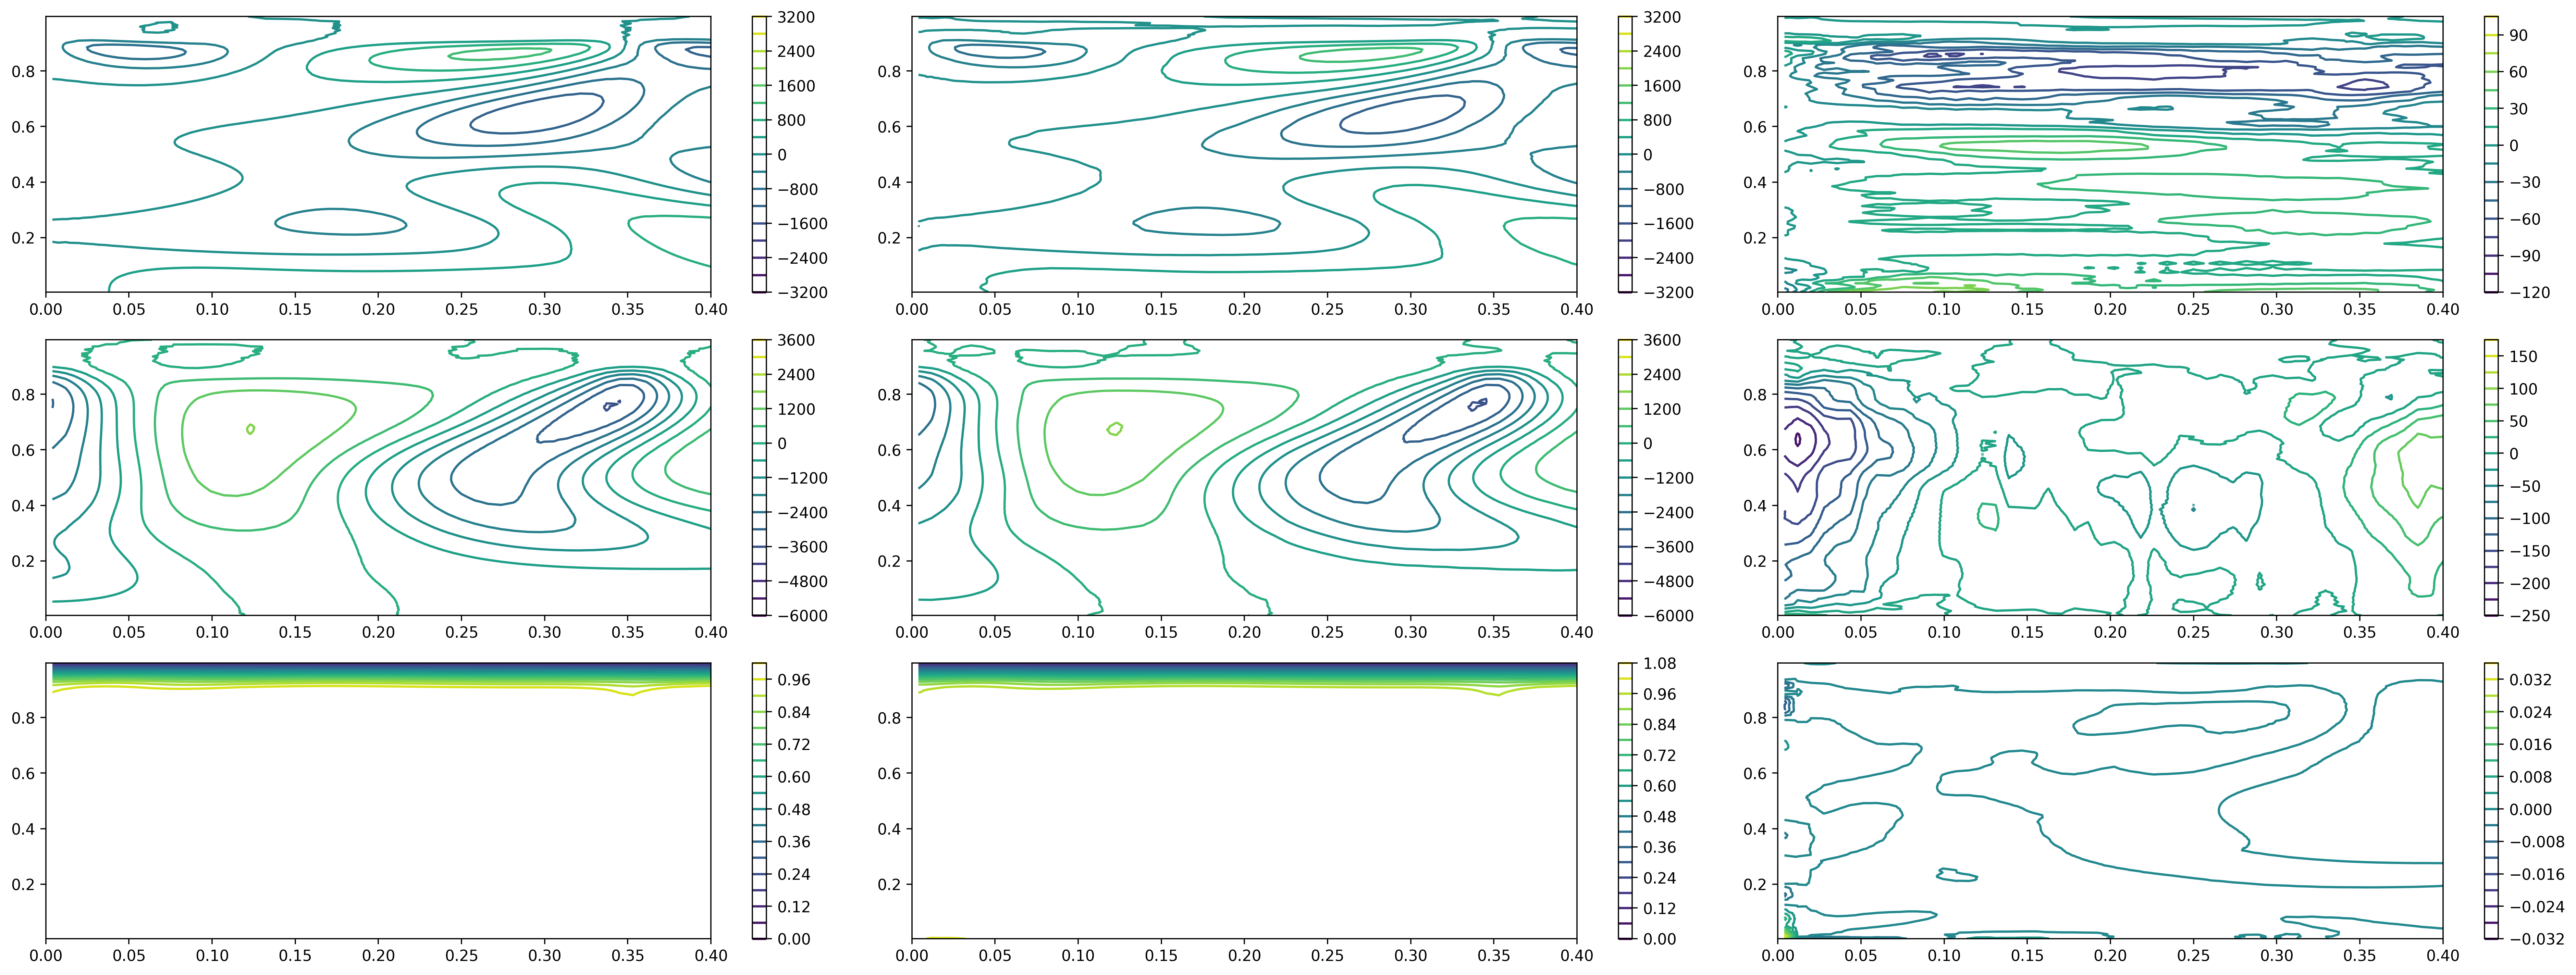

In [17]:
print(t, n_step)
fig = plt.figure(figsize=(24,9),dpi=320)
cntr = 1

for var in ["u", "v", "T"]:
    if var == "u":
        z   = u_g.reshape(1,128,506)
        z_p = u_ml.detach().cpu().numpy().reshape(1,128,506)
    elif var == "v":
        z   = v_g.reshape(1,128,506)
        z_p = v_ml.detach().cpu().numpy().reshape(1,128,506)
    else:
        z   = T_g.reshape(1,128,506)
        z_p = T_ml.reshape(1,128,506)

    for zz in [z, z_p, z-z_p]:
        ax  = fig.add_subplot(3,3,cntr)
        cax = ax.tricontour(xcc[0,0,1:-1,1:-1].flatten(), 
                            ycc[0,0,1:-1,1:-1].flatten(), 
                            zz[0,1:-1,1:-1].flatten(),
                            levels=16)
        ax.set_xlim([0.0,0.4])
        fig.colorbar(cax)
        cntr += 1
plt.tight_layout()
plt.show()

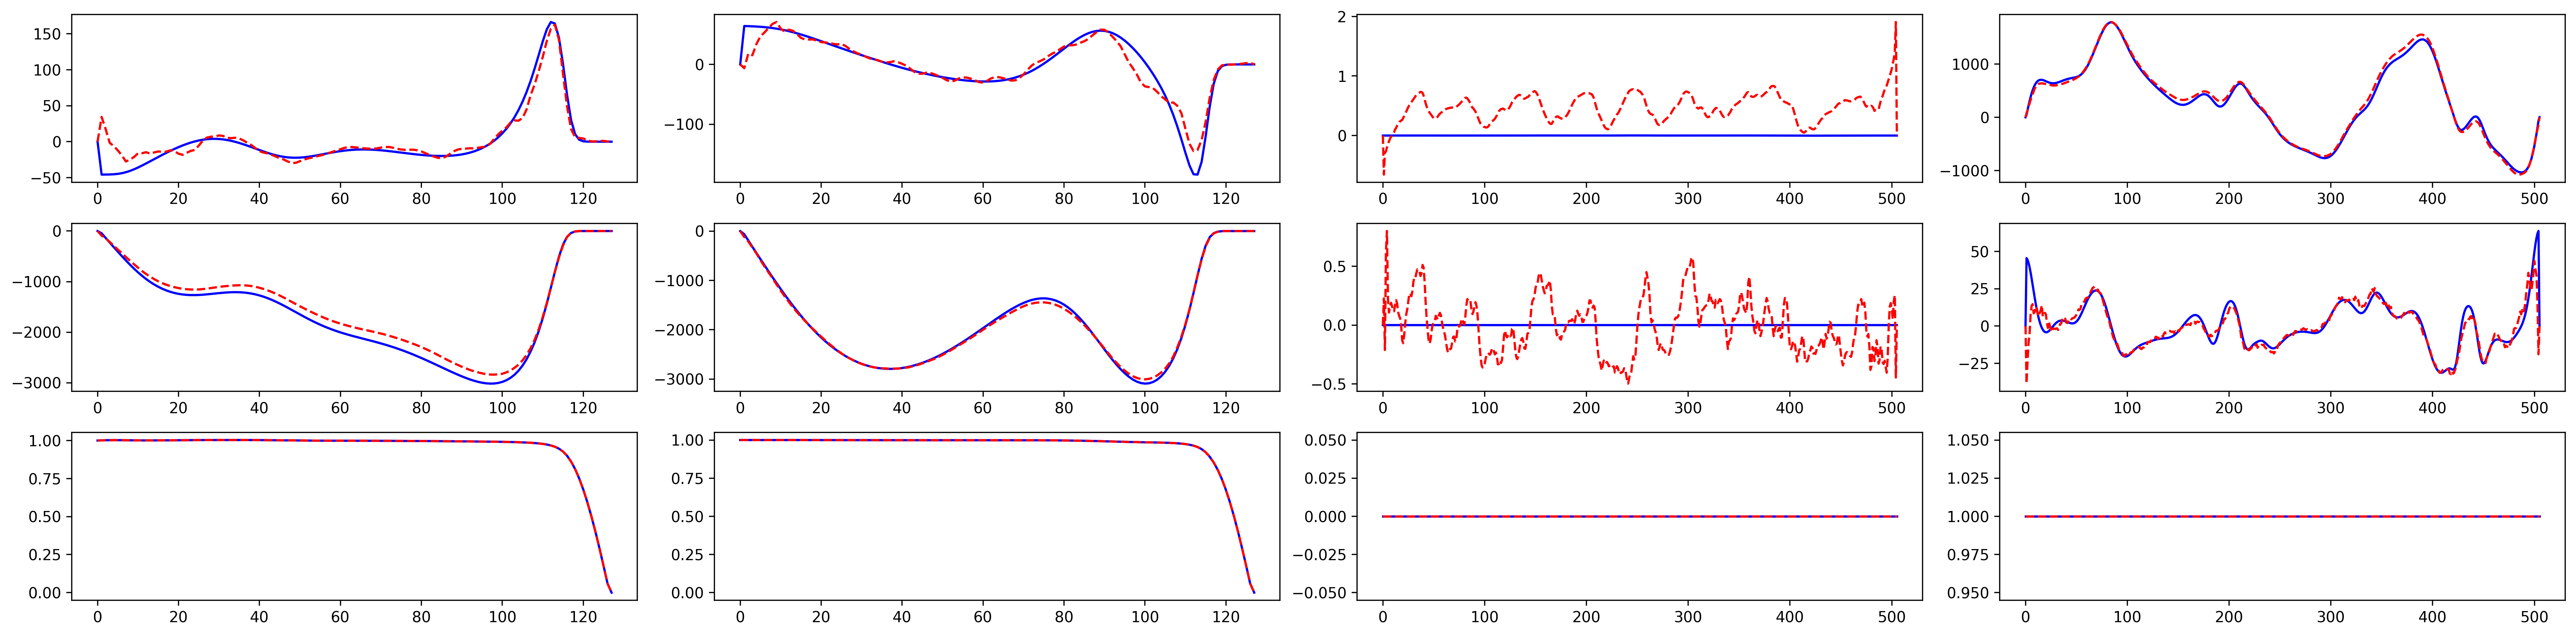

In [18]:
fig = plt.figure(figsize=(24,6),dpi=320)
cntr = 1

for var in ["u", "v", "T"]:
    if var == "u":
        z   = u_g.reshape(1,128,506)
        z_p = u_ml.detach().cpu().numpy().reshape(1,128,506)
    elif var == "v":
        z   = v_g.reshape(1,128,506)
        z_p = v_ml.detach().cpu().numpy().reshape(1,128,506)
    else:
        z   = T_g.reshape(1,128,506)
        z_p = T_ml.reshape(1,128,506)
        
    shift = 0
    ax  = fig.add_subplot(3,4,cntr)
    ax.plot(z[0,:,0+shift], 'b-')
    ax.plot(z_p[0,:,0+shift], 'r--')
    cntr += 1
    
    ax  = fig.add_subplot(3,4,cntr)
    ax.plot(z[0,:,-1-shift], 'b-')
    ax.plot(z_p[0,:,-1-shift], 'r--')
    cntr += 1
    
    ax  = fig.add_subplot(3,4,cntr)
    ax.plot(z[0,-1-shift,:], 'b-')
    ax.plot(z_p[0,-1-shift,:], 'r--')
    cntr += 1
    
    ax  = fig.add_subplot(3,4,cntr)
    ax.plot(z[0,0+shift,:], 'b-')
    ax.plot(z_p[0,0+shift,:], 'r--')
    cntr += 1
    
plt.tight_layout()
plt.show()

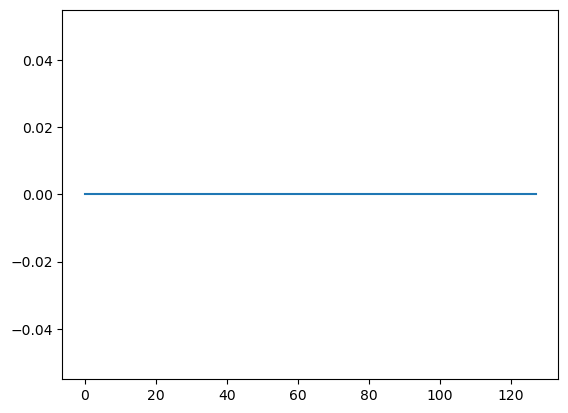

In [27]:
plt.figure()
plt.plot(z[0,:,0]-z_p[0,:,0])
plt.show()